# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

    Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
    Контролировать добросовестность кассиров при продаже алкоголя.

Задание: построить модель, которая по фотографии определит приблизительный возраст человека. 

В распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
labels.head(10)
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


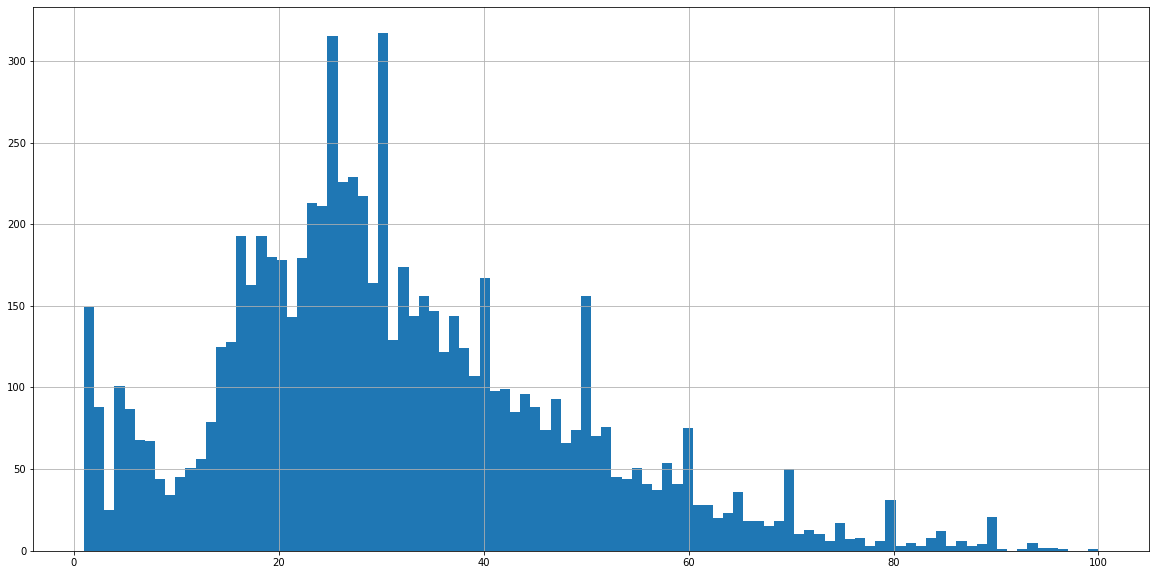

In [3]:
face = labels['real_age'].hist(bins = 100, figsize=(20, 10))

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_datagen_flow = train_datagen.flow_from_dataframe(
                             dataframe=labels,
                             directory='/datasets/faces/final_files/',
                             x_col='file_name',
                             y_col='real_age',
                             target_size=(224, 224),
                             batch_size=32,
                             class_mode='raw',
                             seed=12345)

Found 7591 validated image filenames.


In [5]:
features, target = next(train_datagen_flow)

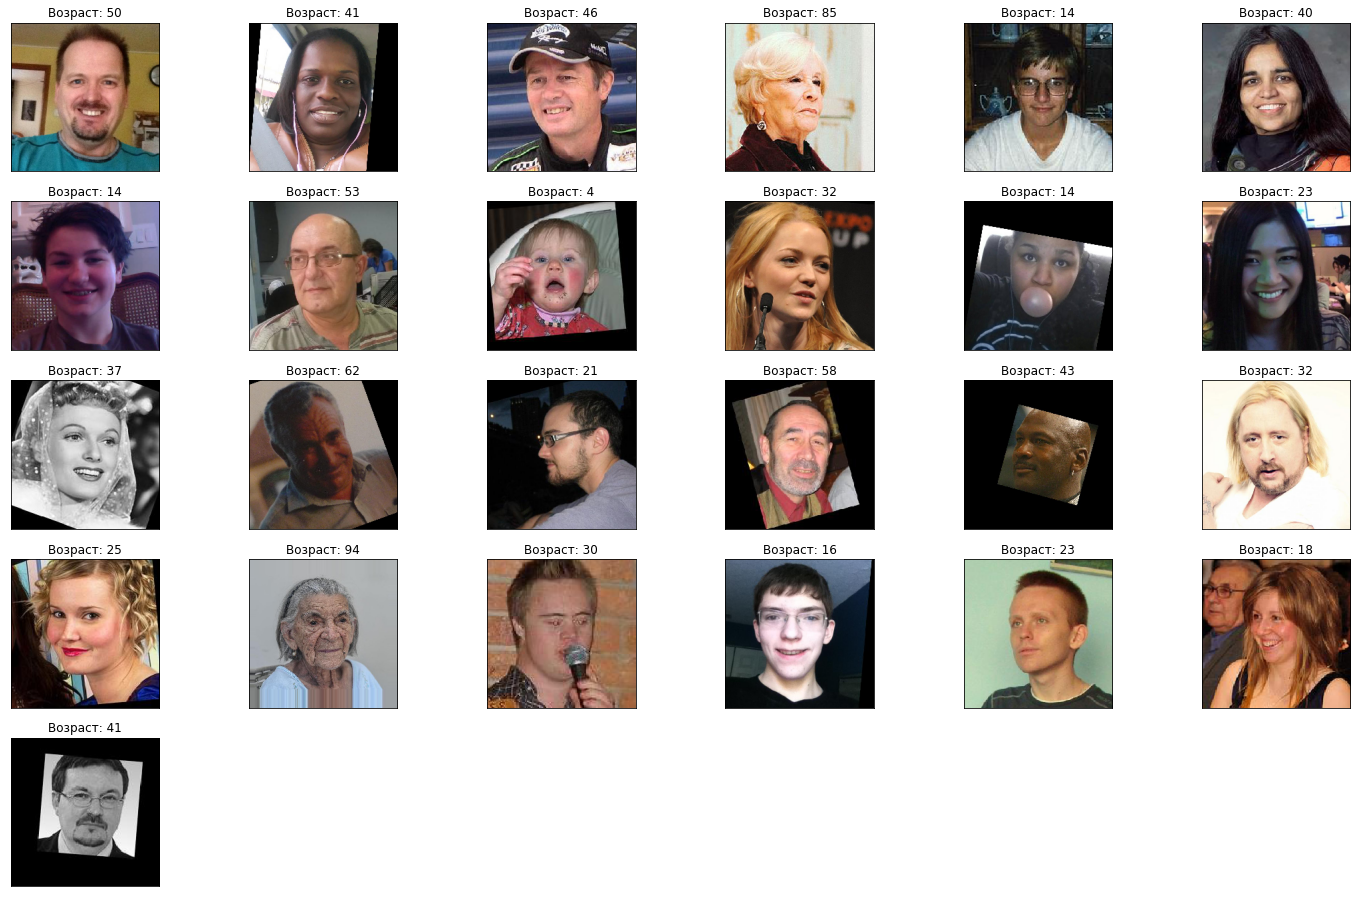

In [17]:
face = plt.figure(figsize=(20,15))
for i in range(25):
    face.add_subplot(6, 6, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title('Возраст: ' + str(target[i]))

Вывод: имеется 7591 фотографий, не так много. Все фото с разных ракурсов и при разном свете. Есть ч/б фото, повернутые по диоганали, в профиль и анфас. Перевернутых вверх ногами не замечено, но возможно они есть. Для минимизации переобучения фото можно повернуть слева на право или сместить в пространтве. 

Выбросы по гистограмме скорее всего есть после разметки возраста 25 лет и 30 лет.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```

import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
 
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255., horizontal_flip=True, height_shift_range=0.2)
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
                                                           directory=path + 'final_files/',
                                                           x_col='file_name',
                                                           y_col='real_age',
                                                           target_size=(224, 224),
                                                           batch_size=16,
                                                           class_mode='raw',
                                                           subset='training',
                                                           seed=12345)
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=labels,
                                                         directory=path + 'final_files/',
                                                         x_col='file_name',
                                                         y_col='real_age',
                                                         target_size=(224, 224),
                                                         batch_size=16,
                                                         class_mode='raw',
                                                         subset='validation',
                                                         seed=12345)
    return test_datagen_flow
 
def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model
 
def train_model(model, train_data, test_data, batch_size=None, 
                                   epochs=15, steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data, 
              validation_data=test_data, 
              batch_size=batch_size, 
              epochs=epochs, 
              steps_per_epoch=steps_per_epoch, 
              validation_steps=validation_steps, 
              verbose=2, 
              shuffle=True)
    return model

```

```

Train for 356 steps, validate for 119 steps

Epoch 1/15

2022-08-29 15:23:03.644678: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10

2022-08-29 15:23:04.233376: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7

356/356 - 108s - loss: 224.6023 - mae: 10.7889 - val_loss: 431.1539 - val_mae: 15.7031

Epoch 2/15

356/356 - 97s - loss: 97.3344 - mae: 7.4982 - val_loss: 129.1498 - val_mae: 8.4028

Epoch 3/15

356/356 - 95s - loss: 73.4074 - mae: 6.5400 - val_loss: 76.6915 - val_mae: 6.5022

Epoch 4/15

356/356 - 96s - loss: 59.1011 - mae: 5.9122 - val_loss: 72.9142 - val_mae: 6.4746

Epoch 5/15

356/356 - 100s - loss: 48.8555 - mae: 5.3474 - val_loss: 99.2516 - val_mae: 7.6792

Epoch 6/15

356/356 - 99s - loss: 40.2199 - mae: 4.9188 - val_loss: 96.6177 - val_mae: 7.5001

Epoch 7/15

356/356 - 93s - loss: 32.8058 - mae: 4.4105 - val_loss: 71.8945 - val_mae: 6.2396

Epoch 8/15

356/356 - 100s - loss: 29.7683 - mae: 4.1509 - val_loss: 71.5913 - val_mae: 6.4862

Epoch 9/15

356/356 - 102s - loss: 25.1868 - mae: 3.8826 - val_loss: 70.7696 - val_mae: 6.3126

Epoch 10/15

356/356 - 103s - loss: 24.3149 - mae: 3.7696 - val_loss: 78.2957 - val_mae: 6.7405

Epoch 11/15

356/356 - 102s - loss: 20.0814 - mae: 3.4697 - val_loss: 87.7368 - val_mae: 6.9680

Epoch 12/15

356/356 - 102s - loss: 17.9948 - mae: 3.2629 - val_loss: 64.0040 - val_mae: 6.0420

Epoch 13/15

356/356 - 96s - loss: 16.5007 - mae: 3.1011 - val_loss: 66.6005 - val_mae: 5.9540

Epoch 14/15

356/356 - 100s - loss: 14.6372 - mae: 2.9499 - val_loss: 63.0011 - val_mae: 5.8297

Epoch 15/15

356/356 - 108s - loss: 14.7872 - mae: 2.9456 - val_loss: 65.2100 - val_mae: 6.0393

WARNING:tensorflow:sample_weight modes were coerced from

  ...

    to  

  ['...']

119/119 - 11s - loss: 65.2100 - mae: 6.0393

Test MAE: 6.0393


```

## Анализ обученной модели

Модель показала хорошие результаты, Test MAE: 6.0393, что меньше заявленного порога равного 8. Поэтому данную модель можно использовать в работе.

Для фото использовали horizontal_flip (горизонтальное отражение) и height_shift_range со сдвигом на 0.2 (вертикальное смещение изображения при увеличении данных).
Были использованы оптимизатор Adam c шагом 0.0001, сеть ResNet50 и активатор ReLu. Для хорошего результата хватило 15 эпох, МАЕ только улучшалось, поэтому переобучения не было.

Модель подходит для определения возраста для оценки покупок для того что бы предлагать товары, которые могут заинтересовать покупателей.

Для того что бы контролировать добросовестность кассиров при продаже алкоголя лучше обучить модель с категориями: клиент старше 18 лет или нет. Этого будет достаточно и проще.

